<center>
    <h1> ILI285 - Computación Científica I  / INF285 - Computación Científica </h1>
    <h2> Conjugate Gradient Method </h2>
    <h2> [[S]cientific [C]omputing [T]eam](#acknowledgements)</h2>
    <h2> Version: 1.1</h2>
</center>

## Table of Contents
* [Introduction](#intro)
* [Gradient Descent](#GDragon)
* [Conjugate Gradient Method](#CGM)
* [Conjugate Gradient Method with Preconditioning](#CGMp)
* [Let's Play: Practical Exercises and Profiling](#LP)
* [Acknowledgements](#acknowledgements)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular
%matplotlib inline
# pip install memory_profiler
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


<div id='intro' />
## Introduction

Welcome to another edition of our IPython Notebooks. Here, we'll teach you how to solve $A\,x = b$ with $A$ being a _symmetric positive-definite matrix_, but the following methods have a key difference with the previous ones: these do not depend on a matrix factorization. The two methods that we'll see are called the Gradient Descent and the Conjugate Gradient Method. On the latter, we'll also see the benefits of preconditioning.

<div id='GDragon' />
## Gradient Descent

This is an iterative method. If you remember the iterative methods in the previous Notebook, to find the next approximate solution $\vec{x}_{k+1}$ you'd add a vector to the current approximate solution, $\vec{x}_k$, that is: $\vec{x}_{k+1} = \vec{x}_k + \text{vector}$. In this method, $\text{vector}$ is $\alpha_{k}\,\vec{r}_k$, where $\vec{r}_k$ is the residue ($\vec{b} - A\,\vec{x}_k$) and $\alpha_k = \cfrac{(\vec{r}_k)^T\,\vec{r}_k}{(\vec{r}_k)^T\,A\,\vec{r}_k}$, starting with some initial guess $\vec{x}_0$. Let's look at the implementation below:

In [62]:
def gradient_descent(A, b, x0, n_iter=10):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    X[0] = x0

    for k in range(1, n_iter):
        r = b - np.dot(A, X[k-1])
        if (all( v == 0 for v in r)): # The algorithm converged
            X[k:] = X[k-1]
            return X
            break
        alpha = np.dot(np.transpose(r), r)/np.dot(np.transpose(r), np.dot(A, r))
        X[k] = X[k-1] + alpha*r
    
    return X

Now let's try our algorithm! But first, let's borrow a function to generate a random symmetric positive-definite matrix, kindly provided by the previous notebook, and another one to calculate the vectorized euclidean metric.

In [63]:
"""
Randomly generates an nxn symmetric positive-
definite matrix A.
"""
def generate_spd_matrix(n):
    A = np.random.random((n,n))
    #constructing symmetry
    A += A.T
    #symmetric+diagonally dominant -> symmetric positive-definite
    deltas = 0.1*np.random.random(n)
    row_sum = A.sum(axis=1)-np.diag(A)
    np.fill_diagonal(A, row_sum+deltas)
    return A

We'll try our algorithm with some matrices of different sizes, and we'll compare it with the solution given by Numpy's solver.

In [64]:
A3 = generate_spd_matrix(3)
b3 = np.ones(3)
x30 = np.zeros(3)

X = gradient_descent(A3, b3, x30, 15)
sol = np.linalg.solve(A3, b3)
print (X[-1])
print (sol)
print (np.linalg.norm(X[-1] - sol)) # difference bewteen gradient_descent's solution and Numpy's solver's solution

[-0.17820154  0.52106981  0.53382729]
[-0.17836737  0.52135731  0.53409502]
0.000426422448857


In [65]:
A10 = generate_spd_matrix(10)
b10 = np.ones(10)
x100 = np.zeros(10)

X = gradient_descent(A10, b10, x100, 15)
sol = np.linalg.solve(A10, b10)
print (X[-1])
print (sol)
print (np.linalg.norm(X[-1] - sol)) # difference bewteen gradient_descent's solution and Numpy's solver's solution

[ 0.0446622   0.0754582   0.05714179  0.05645706  0.06937592  0.05045132
  0.05294166  0.06005202  0.05671544  0.04636633]
[ 0.04466199  0.07545925  0.05714224  0.05645745  0.06937605  0.05045118
  0.05294159  0.06005154  0.05671561  0.04636658]
1.36672300759e-06


In [66]:
A50 = generate_spd_matrix(50)
b50 = np.ones(50)
x500 = np.zeros(50)

X = gradient_descent(A50, b50, x500, 15)
sol = np.linalg.solve(A50, b50)
print (X[-1])
print (sol)
print (np.linalg.norm(X[-1] - sol)) # difference bewteen gradient_descent's solution and Numpy's solver's solution

[ 0.00903531  0.00902351  0.00901697  0.00995673  0.01045713  0.01075561
  0.00992705  0.01101404  0.00978422  0.00888462  0.01146559  0.00841561
  0.01409151  0.01095426  0.00897269  0.01073809  0.01113314  0.00948095
  0.01064304  0.01142139  0.01027172  0.01206779  0.00874802  0.0093409
  0.01013143  0.01134398  0.01099172  0.0105418   0.01050023  0.00991486
  0.0103632   0.01029715  0.00875615  0.01188232  0.00861486  0.01136636
  0.01071254  0.00979824  0.01060024  0.00978044  0.01072061  0.01243879
  0.01369218  0.01153421  0.01071187  0.01049353  0.00906187  0.00858981
  0.00979479  0.01006239]
[ 0.00903531  0.00902351  0.00901697  0.00995674  0.01045713  0.01075561
  0.00992705  0.01101403  0.00978422  0.00888462  0.01146559  0.00841561
  0.01409153  0.01095426  0.00897269  0.01073809  0.01113314  0.00948095
  0.01064304  0.01142139  0.01027172  0.01206779  0.00874802  0.0093409
  0.01013143  0.01134399  0.01099171  0.0105418   0.01050023  0.00991486
  0.0103632   0.01029716  0

As we can see, we're getting good solutions with 15 iterations, even for matrices on the bigger side. However, this method is not used too often; rather, its younger sibling, the Conjugate Gradient Method, is the more preferred choice.

<div id='CGM' />
## Conjugate Gradient Method

This method works by succesively eliminating the $n$ orthogonal components of the error, one by one. The method arrives at the solution with the following finite loop:

In [67]:
def conjugate_gradient(A, b, x0):
    n = A.shape[0]
    X = np.empty((n, n))
    d = b - np.dot(A, x0)
    R = np.empty((n, n))
    X[0] = x0
    R[0] = b - np.dot(A, x0)

    for k in range(1, n):
        if (all( v == 0 for v in R[k-1])): # The algorithm converged
            X[k:] = X[k-1]
            return X
            break
        alpha = np.dot(np.transpose(R[k-1]), R[k-1]) / np.dot(np.transpose(d), np.dot(A, d))
        X[k] = X[k-1] + alpha*d
        R[k] = R[k-1] - alpha*np.dot(A, d)
        beta = np.dot(np.transpose(R[k]), R[k])/np.dot(np.transpose(R[k-1]), R[k-1])
        d = R[k] + beta*d

    return X

The science behind this algorithm is a bit long to explain, but for the curious ones, the explanation is on the official textbook (Numerical Analysis, 2nd Edition, Timothy Sauer). Now let's try it!

In [68]:
A3 = generate_spd_matrix(3)
b3 = np.ones(3)
x30 = np.zeros(3)

X = conjugate_gradient(A3, b3, x30)
sol = np.linalg.solve(A3, b3)
print (X[-1])
print (sol)
print (np.linalg.norm(X[-1]- sol)) # difference bewteen conjugate_gradient's solution and Numpy's solver's solution

[ 1.35271985  0.34037821  0.08049509]
[ 1.40516288  0.69659549 -0.2545157 ]
0.49180611623


In [69]:
A50 = generate_spd_matrix(50)
b50 = np.ones(50)
x500 = np.zeros(50)

X = conjugate_gradient(A50, b50, x500)
sol = np.linalg.solve(A50, b50)
print (X[-1])
print (sol)
print (np.linalg.norm(X[-1]-sol)) # difference bewteen conjugate_gradient's solution and Numpy's solver's solution

[ 0.01190241  0.00927628  0.00957849  0.00957212  0.01082093  0.00876215
  0.01163497  0.01028986  0.00980331  0.00963057  0.00976296  0.00975619
  0.00805716  0.00978794  0.00911269  0.010443    0.01241443  0.01023687
  0.00977655  0.00947738  0.01004634  0.01089766  0.00886436  0.0109383
  0.01157286  0.00937456  0.01337872  0.00919891  0.00843774  0.00952983
  0.00891668  0.00877704  0.01036801  0.00952659  0.01008131  0.01324203
  0.0094448   0.01314565  0.00836897  0.01028022  0.01052006  0.01106342
  0.00934089  0.01201073  0.01333601  0.01117572  0.00998451  0.00865133
  0.01002496  0.01015551]
[ 0.01190241  0.00927628  0.00957849  0.00957212  0.01082093  0.00876215
  0.01163497  0.01028986  0.00980331  0.00963057  0.00976296  0.00975619
  0.00805716  0.00978794  0.00911269  0.010443    0.01241443  0.01023687
  0.00977655  0.00947738  0.01004634  0.01089766  0.00886436  0.0109383
  0.01157286  0.00937456  0.01337872  0.00919891  0.00843774  0.00952983
  0.00891668  0.00877704  0

In [70]:
A100 = generate_spd_matrix(100)
b100 = np.ones(100)
x1000 = np.zeros(100)

X = conjugate_gradient(A100, b100, x1000)
sol = np.linalg.solve(A100, b100)
print (X[-1])
print (sol)
print (np.linalg.norm(X[-1] - sol)) # difference bewteen conjugate_gradient's solution and Numpy's solver's solution

[ 0.00538009  0.00574306  0.00549899  0.00545083  0.00508037  0.00510893
  0.00513874  0.00512237  0.00522686  0.00606851  0.005029    0.00510274
  0.00538952  0.00511507  0.00539495  0.00509579  0.00546477  0.0049069
  0.00521481  0.00520166  0.00506267  0.00554944  0.0051413   0.0054336
  0.00461031  0.00549307  0.00551022  0.00519428  0.00563402  0.00496691
  0.00537251  0.00599037  0.00523061  0.00604818  0.00517442  0.00479914
  0.00507978  0.00519203  0.00480891  0.0056378   0.00537282  0.00566637
  0.00527499  0.00500782  0.00584485  0.0053589   0.00470743  0.00611903
  0.00509751  0.00518512  0.00462353  0.00567439  0.00499571  0.00521962
  0.00620506  0.00502386  0.00508448  0.00484302  0.00499571  0.00580738
  0.00480171  0.00545177  0.00618141  0.00498551  0.00604026  0.00541738
  0.00430637  0.00471201  0.00597907  0.0043611   0.00539174  0.00512181
  0.0051966   0.00491533  0.00498672  0.00519792  0.00491472  0.00475654
  0.00596284  0.00489521  0.00593949  0.00500833  0.0

We can see that for small matrices the error for `gradient_descent` is somewhat smaller than the error for `conjugate_gradient`, but for big matrices this method has an extremely small error, practically zero. Isn't that amazing?!

Here are some questions for the student to think about:
* In which cases can the Conjugate Gradient Method converge in less than $n$ iterations?
* What will happen if you use the Gradient Descent or Conjugate Gradient Method with non-symmetric, non-positive-definite matrices?

<div id='CGMp' />
## Conjugate Gradient Method with Preconditioning

We've seen that the Conjugate Gradient Method works very well, but can we make it better? 

Very often, the convergence rate of iterative methods depends on the condition number of matrix $A$. By preconditioning, we'll reduce the condition number of the problem. The preconditioned version of the problem $A\,x = b$ is: $$M^{-1}\,A\,x = M^{-1}\,b$$ The matrix $M$ must be as close to $A$ as possible and easy to invert. One simple choice is the Jacobi Preconditioner $M = D$, since it shares its diagonal with $A$ and, as a diagonal matrix, is easy to invert. By applying this modification, we'll find that the method converges even faster.

In [71]:
def diag_dot(D, v):
    n = len(D)
    sol = np.zeros(n)
    for i in range(n):
        sol[i] = D[i] * v[i]
    return sol

def conjugate_gradient_J(A, b, x0):
    M = np.diag(A)
    M_p = M**-1
    
    n = A.shape[0]
    X = np.empty((n, n))
    Z = np.empty((n, n))
    R = np.empty((n, n))
    X[0] = x0
    R[0] = b - np.dot(A, x0)
    Z[0] = diag_dot(M_p, R[0])
    d = diag_dot(M_p, R[0])

    for k in range(1, n):
        if (all( v == 0 for v in R[k-1]) and pr): # The algorithm converged
            X[k:] = X[k-1]
            return X
            break
        alpha = np.dot(np.transpose(R[k-1]), Z[k-1]) / np.dot(np.transpose(d), np.dot(A, d))
        X[k] = X[k-1] + alpha*d
        R[k] = R[k-1] - alpha*np.dot(A, d)
        Z[k] = diag_dot(M_p, R[k])
        beta = np.dot(np.transpose(R[k]), Z[k])/np.dot(np.transpose(R[k-1]), Z[k-1])
        d = Z[k] + beta*d

    return X

Now let's try it out:

In [72]:
Aj100 = generate_spd_matrix(100)
bj100 = np.ones(100)
xj1000 = np.zeros(100)

X = conjugate_gradient_J(Aj100, bj100, xj1000)
X2 = conjugate_gradient(Aj100, bj100, xj1000)
sol = np.linalg.solve(Aj100, bj100)
print (np.linalg.norm(X[-1]- sol)) # difference bewteen gradient_descent's solution and Numpy's solver's solution
print (np.linalg.norm(X2[-1]- sol))

3.39353548031e-17
3.27665915265e-17


The absolute errors for both are very much alike and practically zero, but the difference is the _speed_ with which the error decreases, as we'll see in the Exercises section of this notebook.

Can you think of other preconditioners and try them out?

<div id='LP' />
## Let's Play: Practical Exercises and Profiling

First of all, define a function to calculate the progress of the relative error for a given method, that is, input the array of approximate solutions `X` and the real solution provided by Numpy's solver `r_sol` and return an array with the relative error for each step.

In [73]:
def relative_error(X, r_sol):
    n_steps = X.shape[0]
    n_r_sol = np.linalg.norm(r_sol)
    E = np.zeros(n_steps)
    for i in range(n_steps):
        E[i] = np.linalg.norm(X[i] - r_sol) / n_r_sol
    return E

Try the three methods with a small non-symmetric, non-positive-definite matrix. Plot the relative error for all three methods.

In [74]:
n = 10
B = 10 * np.random.random((n,n))
b = 10 * np.random.random(n)
x0 = np.zeros(n)

In [75]:
X1 = gradient_descent(B, b, x0, n)
X2 = conjugate_gradient(B, b, x0)
X3 = conjugate_gradient_J(B, b, x0)
r_sol = np.linalg.solve(B, b)

E1 = relative_error(X1, r_sol)
E2 = relative_error(X2, r_sol)
E3 = relative_error(X3, r_sol)

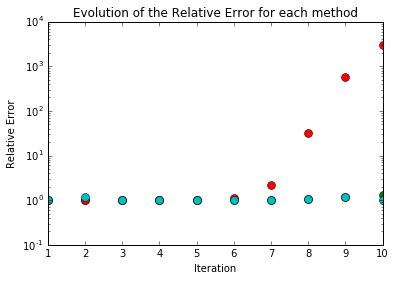

In [76]:
iterations = np.linspace(1, n, n)
plt.xlabel('Iteration')
plt.ylabel('Relative Error')
plt.title('Evolution of the Relative Error for each method')
plt.semilogy(iterations, E1, 'go', markersize=8) # Green spots are for Gradient Descent
plt.semilogy(iterations, E2, 'ro', markersize=8) # Red spots are for Conjugate Gradient
plt.semilogy(iterations, E3, 'co', markersize=8) # Cyan spots are for Conjugate Gradient with Jacobi Preconditioner
plt.show()

As you can see, if the matrix doesn't meet the requirements for these methods, the results can be quite terrible.

Let's try again, this time using an appropriate matrix.

In [77]:
n = 100
A = 10 * generate_spd_matrix(n)
b = 10 * np.random.random(n)
x0 = np.random.random(n)

In [78]:
X1 = gradient_descent(A, b, x0, n)
X2 = conjugate_gradient(A, b, x0)
X3 = conjugate_gradient_J(A, b, x0)
r_sol = np.linalg.solve(A, b)

E1 = relative_error(X1, r_sol)
E2 = relative_error(X2, r_sol)
E3 = relative_error(X3, r_sol)

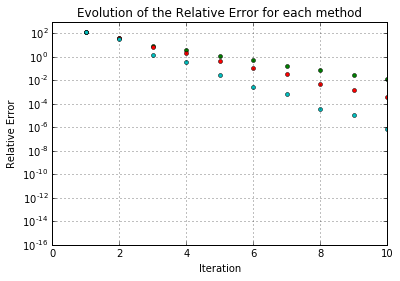

In [79]:
iterations = np.linspace(1, n, n)
plt.xlabel('Iteration')
plt.ylabel('Relative Error')
plt.title('Evolution of the Relative Error for each method')
plt.semilogy(iterations, E1, 'go', markersize=4) # Green spots are for Gradient Descent
plt.semilogy(iterations, E2, 'ro', markersize=4) # Red spots are for Conjugate Gradient
plt.semilogy(iterations, E3, 'co', markersize=4) # Cyan spots are for Conjugate Gradient with Jacobi Preconditioner
plt.grid(True)
plt.xlim(0,10)
plt.show()

Amazing! We started with a huge relative error and reduced it to practically zero in just under 6 iterations (the algorithms all have 100 iterations but we're showing you the first 10). We can clearly see that the Conjugate Gradient Method with Preconditioning needs the least of the three, with the Gradient Descent needing the most.

Let's try with an even bigger matrix!

In [80]:
n = 1000
A = 10 * generate_spd_matrix(n)
b = 10 * np.random.random(n)
x0 = np.random.random(n)

In [81]:
X1 = gradient_descent(A, b, x0, n)
X2 = conjugate_gradient(A, b, x0)
X3 = conjugate_gradient_J(A, b, x0)
r_sol = np.linalg.solve(A, b)

E1 = relative_error(X1, r_sol)
E2 = relative_error(X2, r_sol)
E3 = relative_error(X3, r_sol)

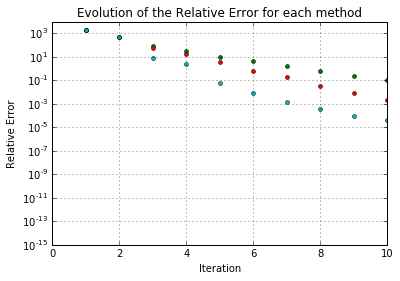

In [82]:
iterations = np.linspace(1, n, n)
plt.xlabel('Iteration')
plt.ylabel('Relative Error')
plt.title('Evolution of the Relative Error for each method')
plt.semilogy(iterations, E1, 'go', markersize=4) # Green spots are for Gradient Descent
plt.semilogy(iterations, E2, 'ro', markersize=4) # Red spots are for Conjugate Gradient
plt.semilogy(iterations, E3, 'co', markersize=4) # Cyan spots are for Conjugate Gradient with Jacobi Preconditioner
plt.grid(True)
plt.xlim(0,10)
plt.show()

We can see that, reached a certain size for the matrix, the amount of iterations needed to reach a small error remains more or less the same. We encourage you to try other kinds of matrices to see how the algorithms behave, and experiment with the codes to your liking. Now let's move on to profiling.

Of course, you win some, you lose some. Accelerating the convergence of the algorithm means you have to spend more of other resources. We'll use the functions `%timeit` and `%memit` to see how the algorithms behave.

In [83]:
A = generate_spd_matrix(100)
b = np.ones(100)
x0 = np.random.random(100)

In [84]:
%timeit gradient_descent(A, b, x0, 100)
%timeit conjugate_gradient(A, b, x0)
%timeit conjugate_gradient_J(A, b, x0)

1000 loops, best of 3: 1.87 ms per loop
100 loops, best of 3: 2.71 ms per loop
100 loops, best of 3: 7.28 ms per loop


In [85]:
%memit gradient_descent(A, b, x0, 100)
%memit conjugate_gradient(A, b, x0)
%memit conjugate_gradient_J(A, b, x0)

peak memory: 133.85 MiB, increment: 0.07 MiB
peak memory: 133.85 MiB, increment: 0.00 MiB
peak memory: 133.85 MiB, increment: 0.00 MiB


We see something interesting here: all three algorithms need the same amount of memory.

What happened with the measure of time? Why is it so big for the algorithm that has the best convergence rate? Besides the end of the loop, we have one other criteria for stopping the algorithm: When the residue r reaches the _exact_ value of zero, we say that the algorithm converged, and stop. However it's very hard to get an error of zero for randomized initial guesses, so this almost never happens, and we can't take advantage of the convergence rate of the algorithms. 

There's a way we can fix this: instead of using this criteria, make the algorithm stop when a certain _tolerance_ is reached. That way, when the error gets small enough (which happens faster for the third method), we can stop and say that we got a good enough solution. We'll give the task of modifying the algorithms to let this happen.

You can try with different matrices, different initial conditions, different sizes, etcetera. Try some more plotting, profiling, and experimenting. Have fun!

<div id='acknowledgements' />
# Acknowledgements
* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. DI UTFSM. April 2016._